In [5]:
import numpy as np 
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', -1)


import sklearn

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, make_scorer, mean_squared_error

#git status, git add , git commit -m "", git push

<ipython-input-5-57d7e6d0810a>:9: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


### All this code is from Machine Learning Bookcamp by Alexey Grigorev Chapter 2 Machine Learning for Regression

In [6]:
data = pd.read_csv('data/car_predictions.csv')

In [7]:
data.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [8]:
data.columns

Index(['Make', 'Model', 'Year', 'Engine Fuel Type', 'Engine HP',
       'Engine Cylinders', 'Transmission Type', 'Driven_Wheels',
       'Number of Doors', 'Market Category', 'Vehicle Size', 'Vehicle Style',
       'highway MPG', 'city mpg', 'Popularity', 'MSRP'],
      dtype='object')

In [9]:
len(data)

11914

In [13]:
#replacing all the column names with lower case and underscore seperators
data.columns = data.columns.str.lower().str.replace(' ','_')

In [22]:
#filtering for columns with the str dtype (need .index otherwise it ouputs values and just shows 'O')
str_cols = list(data.dtypes[data.dtypes == 'object'].index)
str_cols

['make',
 'model',
 'engine_fuel_type',
 'transmission_type',
 'driven_wheels',
 'market_category',
 'vehicle_size',
 'vehicle_style']

In [23]:
#replace empty spaces with underscore in the string columns, there's prob a faster way than a for loop to do this but I'm just following the book
for col in str_cols:
    data[col] = data[col].str.lower().str.replace(' ', '_')

In [24]:
data.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,bmw,1_series_m,2011,premium_unleaded_(required),335.0,6.0,manual,rear_wheel_drive,2.0,"factory_tuner,luxury,high-performance",compact,coupe,26,19,3916,46135
1,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,convertible,28,19,3916,40650
2,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,high-performance",compact,coupe,28,20,3916,36350
3,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,coupe,28,18,3916,29450
4,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,luxury,compact,convertible,28,18,3916,34500


Target variable analysis - MSRP column contains the import info (target variable). The y, which we want to learn to predict. The first step of exploratory analysis is to look at the value of y, typically by checking the y's distribution, using a histogram visulization. 

<AxesSubplot:xlabel='msrp', ylabel='Count'>

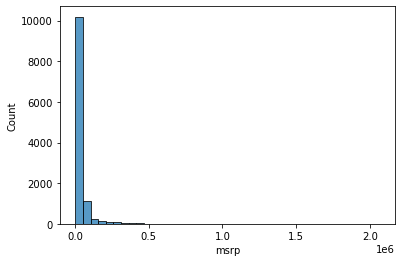

In [25]:
sns.histplot(data['msrp'], bins=40)

<AxesSubplot:xlabel='msrp', ylabel='Count'>

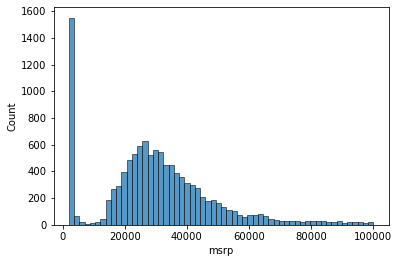

In [28]:
#values below $100,000
sns.histplot(data['msrp'][data['msrp'] < 100000])

In [ ]:
sns.histplot(data[data['msrp'] < 100000])

In [ ]:
# If true, include make and model in Random Forest
# Shows how much make and model come into play, but when when we calculate prices
# we should omit to see if the models are overpriced
includeMakeAndModel = True

# Number of trees in forest
nEstimators = 500

def GetDataMatrix():
    
    # Data frame with make and model
    Xmodelmake = pd.read_csv("../input/data.csv",header=0, usecols=(0,1,2,3,4,5,6,7,8,9,10,11,13,14,));
    
    # Excluding make and model
    if not includeMakeAndModel:
        X = pd.read_csv("../input/data.csv",header=0, usecols=(2,3,4,5,6,7,8,9,10,11,13,14,));
    else:
        X = Xmodelmake
    Y = pd.read_csv("../input/data.csv",header=0, usecols=(15,));

    X, Y, Xmodelmake = shuffle(X, Y, Xmodelmake)
    Xmake = Xmodelmake['Make']
    Xmodel = Xmodelmake['Model']
    
    # Turns categorical data into binary values across many columns
    if not includeMakeAndModel:
        X = pd.get_dummies(X, dummy_na = False, columns=['Engine Fuel Type', 'Transmission Type', 'Driven_Wheels', 'Market Category', 'Vehicle Size', 'Vehicle Style'] );
    else:    
        X = pd.get_dummies(X, dummy_na = False, columns=['Make', 'Model', 'Engine Fuel Type', 'Transmission Type', 'Driven_Wheels', 'Market Category', 'Vehicle Size', 'Vehicle Style'] );
    
    X.insert(0, 'ModelRef', Xmodel);
    X.insert(0, 'MakeRef', Xmake);
    
    # Fill the null values with zeros
    X.fillna(0, inplace=True);
    return (X, Y, Xmodelmake)

##########

(X, Y, Xmodelmake) = GetDataMatrix() #Gets the X,Y

# Turn into a proper one D arrayY = numpy.ravel(Y);
Y_unraveled = np.ravel(Y);

# Split dataset into training and testing
print('Splitting into training and testing...')
X_train, X_test, Y_train, y_test = train_test_split(X, Y_unraveled, test_size=0.10, random_state=32)
MSE_Scorer = make_scorer(mean_squared_error);

# Model/Make columns are only used later on to relate indices to Model/Makes
X_train2 = X_train.drop('MakeRef', axis = 1).drop('ModelRef', axis = 1)
X_test2 = X_test.drop('MakeRef', axis = 1).drop('ModelRef', axis = 1)

# Train using Random Forest
print('Training classifier...')
clf = RandomForestRegressor(n_estimators=nEstimators, max_features="sqrt");
# The gradient boosting classifier didnt finish running
# clf = GradientBoostingClassifier(n_estimators=5)
clf = clf.fit(X_train2, Y_train);
print("Done training best classifier.")

print('Calculating error...')
y_pred = clf.predict(X_test2);
scores = cross_val_score(clf,X_test2,y_test, cv = 5)
print()

print("Scores:")
print(scores);
print("Mean absolute error:");
mean_error = sum(abs(y_test-y_pred))/len(y_test);
print(mean_error);
print("Mean percent error: ")
print(mean_error/np.mean(y_test))
print()

print("ypred:");
print(y_test);
print(y_pred);
np.savetxt("ypred_test.csv",(y_pred,y_test),delimiter=",");
print()